# SentiMind, Sentence Sentiment Clasfier
### Input and Output
The input is a sentence or sentences. The output is a list of 0-27 represent one or more sentiment including admiration, gratitude, surprise, or neutural.

### Architecture
the model or architecture we plan is 
1. Tokenizing the input
2. use one of the pretrained encoder transformer from hugging face to process the embedding, make it context aware to increase accuracy.
3. pass the context aware embedding to multiple layer of CNN, maybe 6 layers, each of a configuration of VGG level. 
4. connect the output of CNN to flattened and connect to FNN to make final classfication.
5. softmax the result, include all class with prob greater than a threshold. For example, if a class is more than 0.3, include as output. anger 0.4, remorese 0.35, rest 0.25, output [anger, remorses].

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np
from pprint import pprint
from tqdm import tqdm

# We may choose a GPU if we have one on our machine
if torch.backends.cuda.is_built():
  # if we have cuda
  # usually on Windows machines with GPU
  device = "cuda"
elif torch.backends.mps.is_built():
  # if we have MPS
  # usually on MAC
  device = "mps"
else:
  # if not we should use our CPU
  device = "cpu"


id_to_class = {
    0: 'Admiration',
    1: 'Amusement',
    2: 'Anger',
    3: 'Annoyance',
    4: 'Approval',
    5: 'Caring',
    6: 'Confusion',
    7: 'Curiosity',
    8: 'Desire',
    9: 'Disappointment',
    10: 'Disapproval',
    11: 'Disgust',
    12: 'Embarrassment',
    13: 'Excitement',
    14: 'Fear',
    15: 'Gratitude',
    16: 'Grief',
    17: 'Joy',
    18: 'Love',
    19: 'Nervousness',
    20: 'Optimism',
    21: 'Pride',
    22: 'Realization',
    23: 'Relief',
    24: 'Remorse',
    25: 'Sadness',
    26: 'Surprise',
    27: 'Neutral'
    }

LOAD_MODEL = False
SAVE_MODEL = True

##### Step 1 and 2: Tokenizing the input, use one of the pretrained encoder transformer from hugging face to process the embedding, make it context aware to increase accuracy.

In [2]:
# Choose a model
model_name = "roberta-base"  # Replace with "albert-base-v2", "distilroberta-base", or "huawei-noah/TinyBERT_General_4L_312D", "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder_model = AutoModel.from_pretrained(model_name).to(device)
embedding_size = encoder_model.config.hidden_size

for param in encoder_model.parameters():
    param.requires_grad = False


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\26597\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def context_aware_embed(texts):
    """ 
    using encoder-only transformers, process the input texts to context-aware embeddings for downstream tasks
    """
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = encoder_model(**inputs)
    return outputs.last_hidden_state

In [10]:
# Example input text
texts = ["I love this product! something, no matter how long as long as this is", "The experience was terrible that I don't want to come any more and the number is depend on the longest sequence"]

context_aware_embedding = context_aware_embed(texts)
print(f"Shape of context awared embedding: {context_aware_embedding.shape}")  # [2, 25, 768] -> [batch_size, max_length_of_entire_batch, embedding_size]

Shape of context awared embedding: torch.Size([2, 24, 768])


### Step 3: pass the context aware embedding to multiple layers of CNN

In [5]:
class CNN_Model(torch.nn.Module):
    def __init__(self, embedding_size):
        """
        k1 k2: conv layer size, conv layer size: k1 x embedding_size
        n1 n2: channel #
        """
        super().__init__()
        k1 = 2
        k2 = 4
        # channel_size1 = 10
        # channel_size2 = 20

        kernal_size1 = (k1, embedding_size)
        kernal_size2 = (k2, embedding_size)

        # self.conv1 = torch.nn.Conv2d(1, channel_size1, kernal_size1, bias=False)
        self.conv1_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=kernal_size1),
            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(k1, 1)),
        ])
        self.batchnorm1 = nn.BatchNorm2d(256)


        # self.conv2 = torch.nn.Conv2d(1, channel_size2, kernal_size2, bias=False)
        self.conv2_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=kernal_size2),
            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(k2, 1)),
        ])
        self.batchnorm2 = nn.BatchNorm2d(256)
        # Linear Layers:
        self.line1 = nn.Linear(512, 2048)
        self.line2 = nn.Linear(2048, 1024)
        self.line3 = nn.Linear(1024, 28)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm3 = nn.BatchNorm1d(2048)
        self.batchnorm4 = nn.BatchNorm1d(1024)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embedded_text):
        # embedded_text: [2, 25, 768] batch 2, all sentences max length 25, embedding size 768
        sentence_emb = embedded_text.unsqueeze(1)  # for conv2d()

        sentence_len = sentence_emb.size(2)
        x1, x2 = sentence_emb, sentence_emb

        for conv in self.conv1_layers:
            dropout = self.dropout(x1)
            x1 = F.relu(conv(dropout))
            x1 = self.batchnorm1(x1)
            

        for conv in self.conv2_layers:
            dropout = self.dropout(x2)
            x2 = F.relu(conv(dropout))
            x2 = self.batchnorm2(x2)

        # conv1_out = self.conv1(sentence_emb)
        # conv1_out: [2, 10, 24, 1] batch 2, channel 10, output length 24, dummy 1
        # conv2_out = self.conv2(sentence_emb)
        # conv1_out: [2, 20, 22, 1] batch 2, channel 10, output length 22, dummy 1

        # conv1_out = torch.nn.functional.relu(conv1_out)
        # conv2_out = torch.nn.functional.relu(conv2_out)

        conv1_out = x1.squeeze(3)
        conv2_out = x2.squeeze(3)

        # maxpool
        conv1_out = F.max_pool1d(conv1_out, conv1_out.size(2)).squeeze(2)  # [batch_size, n1]
        # conv1_out: [2, 10]
        conv2_out = F.max_pool1d(conv2_out, conv2_out.size(2)).squeeze(2)  # [batch_size, n2]

        after_maxpool = torch.cat((conv1_out, conv2_out), 1)
        after_maxpool = self.dropout(after_maxpool)

        line1_out = F.relu(self.line1(after_maxpool))
        line1_out = self.batchnorm3(line1_out)
        line1_out = self.dropout(line1_out)
        
        line2_out = F.relu(self.line2(line1_out))
        line2_out = self.batchnorm4(line2_out)
        line3_out = self.line3(line2_out)
        # return torch.sigmoid(self.output_model(after_maxpool))  # apply sigmoid
        distribution = line3_out
        return self.sigmoid(distribution)

In [11]:
CNN = CNN_Model(embedding_size).to(device)
context_aware_embedding = context_aware_embedding.to(device)  # Add channel dimension
output = CNN(context_aware_embedding)

if LOAD_MODEL:
    try:
        # Load the model weights
        CNN.load_state_dict(torch.load("cnn_model_weights.pt"))
    except Exception as e:
        print(e)

In [12]:
print(output)

tensor([[0.5026, 0.4586, 0.2809, 0.5480, 0.3185, 0.3474, 0.4750, 0.2872, 0.2604,
         0.5552, 0.2642, 0.6342, 0.3678, 0.3710, 0.3613, 0.6246, 0.5560, 0.6608,
         0.4128, 0.4371, 0.6316, 0.5779, 0.5597, 0.7127, 0.6444, 0.2300, 0.3493,
         0.5647],
        [0.5048, 0.5556, 0.7085, 0.4656, 0.6722, 0.6506, 0.5206, 0.7069, 0.7514,
         0.4498, 0.7247, 0.3539, 0.6212, 0.6162, 0.6520, 0.3855, 0.4425, 0.3386,
         0.5918, 0.5667, 0.3626, 0.4290, 0.4282, 0.2884, 0.3471, 0.7788, 0.6579,
         0.4218]], device='cuda:0', grad_fn=<SigmoidBackward0>)


### Dataset
[go emotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)


#### Import the dataset

In [13]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

#### Stats of the go_emotions dataset

In [14]:
from collections import Counter

# Initialize a counter to track label frequencies
label_counter = Counter()
# Iterate over each example in the training dataset
for example in ds['train']:
    # 'labels' is a list of integers representing emotion labels
    labels = example['labels']
    # Update the counter with the labels
    label_counter.update(labels)

emotion_names = list(id_to_class.values())

# Print the frequency of each emotion label
for idx, emotion in enumerate(emotion_names):
    print(f"{emotion}: {label_counter[idx]}")

print(f"On average, each sentence has {sum(label_counter.values())} / {len(ds['train'])} = {sum(label_counter.values()) / len(ds['train'])} emotions")


Admiration: 4130
Amusement: 2328
Anger: 1567
Annoyance: 2470
Approval: 2939
Caring: 1087
Confusion: 1368
Curiosity: 2191
Desire: 641
Disappointment: 1269
Disapproval: 2022
Disgust: 793
Embarrassment: 303
Excitement: 853
Fear: 596
Gratitude: 2662
Grief: 77
Joy: 1452
Love: 2086
Nervousness: 164
Optimism: 1581
Pride: 111
Realization: 1110
Relief: 153
Remorse: 545
Sadness: 1326
Surprise: 1060
Neutral: 14219
On average, each sentence has 51103 / 43410 = 1.1772172310527529 emotions


In [15]:
class GoEmotionsDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item['text']
        labels = item['labels']
        return text, labels
    

# We need to process the lables because label could be different size, ie, some has label [Anger], some have label [Sadness, Nervousness]
# Solution: convert all labels to one-hot.
def my_collate_fn(batch):
    texts, labels = zip(*batch)
    # Initialize a tensor for multi-hot encoding
    multi_hot_labels = torch.zeros((len(labels), 28), dtype=torch.float32)
    for i, label_list in enumerate(labels):
        for label in label_list:
            multi_hot_labels[i, label - 1] = 1.0
    return list(texts), multi_hot_labels


train_dataset = GoEmotionsDataset(ds['train'])
val_dataset = GoEmotionsDataset(ds['validation'])
test_dataset = GoEmotionsDataset(ds['test'])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
# val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=my_collate_fn)


In [16]:
print(len(train_dataloader))
for each in train_dataloader:
    texts, labels = each
    print(context_aware_embed(texts).shape)
    break

10853
torch.Size([4, 33, 768])


### Train

In [17]:
def infer(probs, threshold):
    top_values, top_indices = probs.topk(probs.shape[0])
    print(top_values)
    print(top_indices)
    selected = top_indices[0:1]
    for i in range(1, probs.shape[0]):
        pre_value = top_values[i-1].item()
        value = top_values[i].item()
        index = top_indices[i:i+1]
        print(pre_value, value, index)
        if value > threshold * pre_value:
            selected = torch.cat((selected, index), dim=0)
        else:
            return selected
    return selected

def calculate_acc(predicted, labels):
    # Convert tensors to lists of indices for each row
    labels = [row.nonzero(as_tuple=True)[0].tolist() for row in labels]
    predicted = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted]

    # Calculate accuracy
    correct = 0
    total = 0

    for label, pred in zip(labels, predicted):
        # Convert to sets for easier comparison
        label_set = set(label)
        pred_set = set(pred)

        # Count matches
        correct += len(label_set.intersection(pred_set))
        total += len(label_set.union(pred_set))

    # Return accuracy as a float (handle edge case of total = 0)
    return correct / total if total > 0 else 0.0

def test(model, dataset, loss_function, device):
    """ 
    model: model to be trained
    dataset: Dataset type or its descendant, to feed into DataLoader
    """
    test_dataloader = DataLoader(dataset, batch_size=100, shuffle=True, collate_fn=my_collate_fn)
    # we first move our model to the configured device
    model = model.to(device = device)

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for test
    with torch.no_grad():
        risk = 0  ## COMPLETED ##
        accuracy = 0  ## COMPLETED ##

        # here we are only evaluating the model
        ## COMPLETED ##
        model.eval()
        # loop over test mini-batches
        for i, (texts, labels) in enumerate(test_dataloader):
            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            # labels = labels.to(torch.float32).unsqueeze(dim=1).to(device=device)  ## COMPLETED ##

            # move tensors to the configured device
            # images = images.to(device=device)
            # labels = ## COMPLETE ##

            # forward pass
            context_aware_emb = context_aware_embed(texts)
            labels = labels.to(device)
            outputs = model(context_aware_emb)  ## COMPLETED ##
            loss = loss_function(outputs, labels)  ## COMPLETED ## using loss_function

            # determine the class of output from sigmoid output
            predicted = outputs >= 0.5
            # TODO: move to infer()
            # TODO: find appropriate threshold 
            # TODO: if predicted is none, pick highest
            predicted = predicted.int()

            # compute the fraction of correctly predicted labels
            # correct_predict = (predicted == labels).sum() / 28  ## COMPLETED ##  # TODO: consider partially correct answer, this is very wrong now: a lot of 0 == 0 in 28 classes counted for correct answer solution: accuracy calculation 

            risk += loss.item()
            accuracy += calculate_acc(predicted, labels)

        # average test risk and accuracy over the whole test dataset
        test_risk = risk / len(test_dataloader)  ## COMPLETED ##
        test_accuracy = accuracy / len(test_dataloader)  ## COMPLETED ##

    return test_risk, test_accuracy


def train(model, dataset, num_epochs, lr, batch_size, device=device):
    """ 
    model: model to be trained
    dataset: Dataset type or its descendant, to feed into DataLoader
    """

    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    # we first move our model to the configured device
    model = model.to(device = device)

    # set loss function to the corrent one
    loss_function = nn.BCELoss()  ## COMPLETED ##

    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # using Adam optimizer in PyTorch + parameters in the assignment

    # Initiate the values
    train_risk = []  ## COMPLETED ##
    test_risk = []  ## COMPLETED ##
    test_accuracy = []  ## COMPLETED ##


    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0  # initiate

        # tell pytorch that you start training
        model.train()
        # loop over training data
        for i, (texts, labels) in tqdm(enumerate(train_dataloader)):
            # process texts with encoder transformer to make them context aware embeddings
            context_aware_emb = context_aware_embed(texts)

            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            # labels = labels.to(torch.float32).unsqueeze(dim=1).to(device=device)  ## COMPLETED ##

            # move tensors to the configured device
            # images = images.to(device = device)
            # labels = ## COMPLETE ##
            context_aware_emb = context_aware_emb.to(device)
            labels = labels.to(device=device)
            # forward pass
            outputs = model(context_aware_emb)  ## COMPLETED ##
            loss = loss_function(outputs, labels)  ## COMPLETED ##

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            ## COMPLETED ##
            loss.backward()
            # one step of gradient descent
            ## COMPLETED ##
            optimizer.step()

        # first we tell pytorch we are doing evaluation (reassure it, as we have already included it in test())
        ## COMPLETED ##
        model.eval()
        # test out model after update by the optimizer
        risk_epoch, accuracy_epoch = test(model, val_dataset, loss_function, device)  ## COMPLETED ## with test()

        # collect losses and accuracy
        train_risk.append(risk / len(train_dataloader))
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # we can print a message every second epoch
        if (epoch+1) % 2 == 0:
            print(f"accuracy_epoch: {accuracy_epoch}")  ## COMPLETED ## write your message
                
            

    # plot the training and test losses
    plt.plot([i+1 for i in range(num_epochs)], train_risk, label='train')
    plt.plot([i+1 for i in range(num_epochs)], test_risk, label='test')
    plt.legend()
    plt.title('Train and Test Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # plot the test accuracy
    plt.plot([i+1 for i in range(num_epochs)], test_accuracy)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    print(train_risk, test_risk, test_accuracy)

In [18]:
loss_function = nn.BCELoss()
test(CNN, test_dataset, loss_function, device)

(0.6953344767743891, 0.021373231667479037)

### Train!

340it [02:13,  2.54it/s]
340it [02:14,  2.52it/s]


accuracy_epoch: 0.3400885290847193


340it [02:14,  2.53it/s]
340it [02:13,  2.54it/s]


accuracy_epoch: 0.36709464096456895


340it [02:14,  2.52it/s]
340it [02:14,  2.52it/s]


accuracy_epoch: 0.3701716497903721


340it [01:55,  2.94it/s]
340it [01:54,  2.97it/s]


accuracy_epoch: 0.38243477825544453


340it [01:55,  2.94it/s]
340it [01:55,  2.95it/s]


accuracy_epoch: 0.3774846975404821


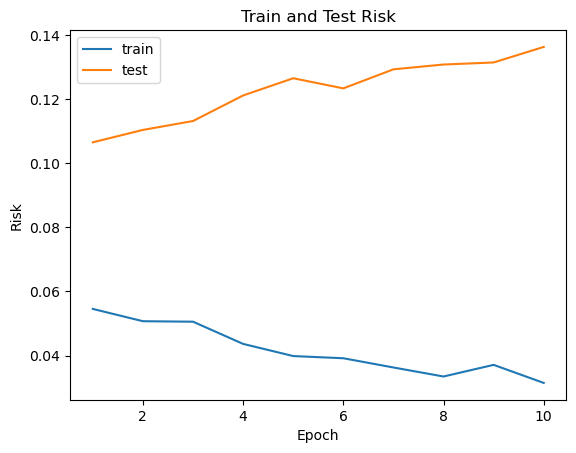

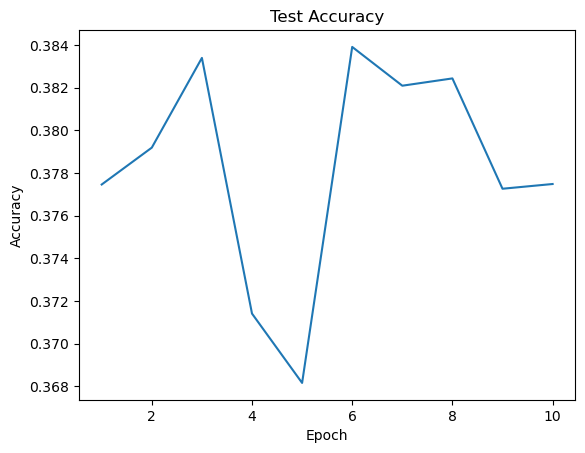

[0.0545438987257726, 0.050708477834568305, 0.05055962378049598, 0.04363664715715191, 0.03984722212943084, 0.03916394750532858, 0.03628486542798141, 0.033474610696601514, 0.037104115366716595, 0.031471637335112865] [0.10648800784891302, 0.11035039221698588, 0.11312815316698768, 0.12109341065992009, 0.1264633452350443, 0.12330383130095222, 0.1292429802092639, 0.13074039085344835, 0.13137907453558662, 0.13622768765146082] [0.37746118641069343, 0.3791899031557989, 0.3833958602753437, 0.37141091784132796, 0.3681605086904501, 0.38391093556703526, 0.38209294469641836, 0.38243477825544453, 0.3772632642575963, 0.3774846975404821]


In [20]:
# CNN = CNN_Model(embedding_size)
train(model=CNN, dataset=train_dataset, num_epochs=10, lr=0.0005, batch_size=128, device=device)

In [15]:
# try:
#     # Load the model weights
#     CNN.load_state_dict(torch.load("cnn_model2_weights.pt"))
# except Exception as e:
#     print(e)

In [16]:
print(f"text:{ds['train'][0]['text']}\n label: {id_to_class[ds['train'][0]['labels'][0]]}")

CNN.eval()
    # test out model after update by the optimizer
risk_epoch, accuracy_epoch = test(CNN, train_dataset, loss_function, device)
print(f"Post Train Accuracy: {accuracy_epoch}")

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 'labels': [25],
 'id': 'eecwqtt'}

In [ ]:
sample_input1 = "I'm really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!"

result = CNN(context_aware_embed(sample_input1))

# Save the model weights
if SAVE_MODEL:
    torch.save(CNN.state_dict(), "cnn_model_weights.pt")

In [ ]:
# Use torch.topk to find the top 2 values and their indices
top_values, top_indices = torch.topk(result, k=2, dim=1)

# Extract the highest and second-highest values and their indices
highest_value = top_values[0, 0].item()
highest_index = top_indices[0, 0].item()
second_highest_value = top_values[0, 1].item()
second_highest_index = top_indices[0, 1].item()

print(f"Highest value: {highest_value} for class: {id_to_class[highest_index]}")
print(f"Second highest value: {second_highest_value} for class: {id_to_class[second_highest_index]}")

Highest value: 0.7253251075744629 for class: Remorse
Second highest value: 0.4057180881500244 for class: Relief
